In the previous notebook, we have trained a MVCNN architecture. The training results as displayed by Tensorboard can be seen below:

![tensorboard](../data/training_results.JPG)


In this notebook we will look at the champion models performance. In particular we will assess the model performance when some of the instance images belong to a different class.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
from torch import Tensor
import torchmetrics

from model.mvcnn import MVCNNClassifier
from dataset.mvcnn_data_module import MVCNNDataModule

/mnt/d/coding/git/TomaszKaleczyc/MVCNN_training/environment/mvcnn_train/lib/python3.6/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


## Data preparation

Let's import the champion model from the training phase:

In [2]:
champion_model_path = '../output/lightning_logs/version_0/checkpoints/mvcnn-epoch=14-validation/f1=0.812.ckpt'
model = MVCNNClassifier.load_from_checkpoint(champion_model_path)

Feature extractor weights frozen


Now let's import validation data to aid our analysis:

In [3]:
NUM_CLASSES = 4
data_module = MVCNNDataModule(num_classes=NUM_CLASSES)
dataset = data_module.get_dataset('val')

Dataset type: TRAIN
------------------------------------------------------------
Class name: AIRPLANE
Total number of instances: 80
Total number of images: 960
------------------------------------------------------------
Class name: BATHTUB
Total number of instances: 80
Total number of images: 960
------------------------------------------------------------
Class name: BED
Total number of instances: 80
Total number of images: 960
------------------------------------------------------------
Class name: BENCH
Total number of instances: 80
Total number of images: 960
Dataset type: TEST
------------------------------------------------------------
Class name: AIRPLANE
Total number of instances: 20
Total number of images: 240
------------------------------------------------------------
Class name: BATHTUB
Total number of instances: 20
Total number of images: 240
------------------------------------------------------------
Class name: BED
Total number of instances: 20
Total number of images: 

## Example

Let's look at an example of a single instance where we will replace some of the correct instance images with images belonging to a different class:

In the example we will replace two images of a selected instance with images belonging to a different class:

In [4]:
def view_image_tensor(image_tensor: Tensor):
    """
    Displays an image based on the tensor values
    """
    num_imgs, depth, height, width = image_tensor.shape

    canvas = np.zeros((height, width * num_imgs, depth))

    for image_no in range(num_imgs):
        canvas[0:height, image_no * width : (image_no + 1) * width, 0 : 3] = image_tensor[image_no].transpose(0, -1).flip(-1)

    plt.figure(figsize=(25,10))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()


def get_incorrect_image_tensor(instance, dataset, num_incorrect_images):
    """
    Returns the image tensor with the replaced images
    """
    output_image_tensor = instance.get_image_tensor()
    target_class = instance.class_id

    while True:
        incorrect_instance = dataset.get_random_instance()
        if incorrect_instance.class_id != target_class:
            break

    incorrect_instance_images = incorrect_instance.get_image_tensor()
    for idx in range(num_incorrect_images):
        output_image_tensor[idx] = incorrect_instance_images[idx]
        
    return output_image_tensor

Target: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


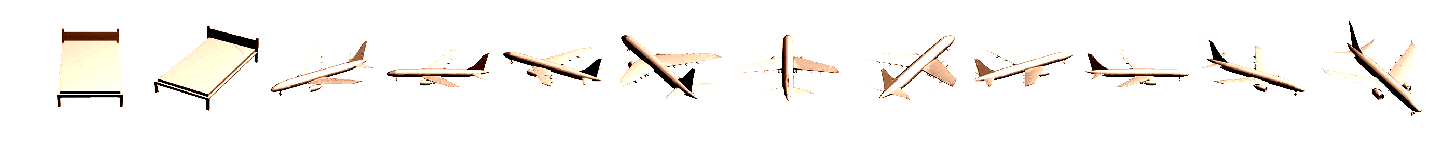

In [5]:
instance = dataset.get_instance(1)
num_incorrect_images = 2

target_class = instance.class_id
print('Target:', target_class)


output_image_tensor = get_incorrect_image_tensor(instance, dataset, num_incorrect_images)

view_image_tensor(output_image_tensor)

Let's see what class has the champion model predicted for this image set:

In [6]:
model.predict(output_image_tensor)

/mnt/d/coding/git/TomaszKaleczyc/MVCNN_training/src/model_classes/mvcnn.py:185: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(output)


(tensor([0]),
 tensor([[9.9943e-01, 1.7558e-23, 5.6997e-04, 2.2651e-18]],
        grad_fn=<SoftmaxBackward>))

It seems two incorrect images was not enough to fool the model. Let's compare it with the results on the original (all correct) image set:

In [7]:
model.predict(instance.get_image_tensor())

(tensor([0]),
 tensor([[1.0000e+00, 7.5072e-28, 9.0446e-09, 7.7691e-26]],
        grad_fn=<SoftmaxBackward>))

## Analysis

Now let's run the analysis on the whole validation dataset. We will test how replacing a number of images (up to a total of 5/12)  with images belonging to a different class will affect the F1 score of the validation dataset:

In [9]:
def test_score_with_incorrect_images(dataset, model, num_incorrect_images):
    """
    Returns the F1 for the dataset predictions where each
    instance has a given number of images belonging to an incorrect class
    """
    num_iterations = len(dataset)

    f1 = torchmetrics.F1()

    actuals = torch.zeros((num_iterations, NUM_CLASSES))
    predictions = torch.zeros((num_iterations, NUM_CLASSES))

    for idx in tqdm(range(num_iterations)):
        instance = dataset.get_instance(idx)
        actuals[idx, instance.class_id] = 1

        output_image_tensor = get_incorrect_image_tensor(instance, dataset, num_incorrect_images)
        predicted_class, _ = model.predict(output_image_tensor)
        predictions[idx, predicted_class] = 1
        
    f1.update(actuals, predictions.argmax(1))
    score = f1.compute()
    return float(score)


Main loop of the current analysis:

In [10]:
scores = {}

for num_incorrect_images in range(6):
    print('='*40)
    print('Total of incorrect images:', num_incorrect_images)
    score = test_score_with_incorrect_images(dataset, model, num_incorrect_images)
    print(f'Score: {score:.2f}')
    scores[num_incorrect_images] = score


Total of incorrect images: 0


  0%|          | 0/80 [00:00<?, ?it/s]

Score: 0.81
Total of incorrect images: 1


  0%|          | 0/80 [00:00<?, ?it/s]

Score: 0.76
Total of incorrect images: 2


  0%|          | 0/80 [00:00<?, ?it/s]

Score: 0.69
Total of incorrect images: 3


  0%|          | 0/80 [00:00<?, ?it/s]

Score: 0.70
Total of incorrect images: 4


  0%|          | 0/80 [00:00<?, ?it/s]

Score: 0.64
Total of incorrect images: 5


  0%|          | 0/80 [00:00<?, ?it/s]

Score: 0.62


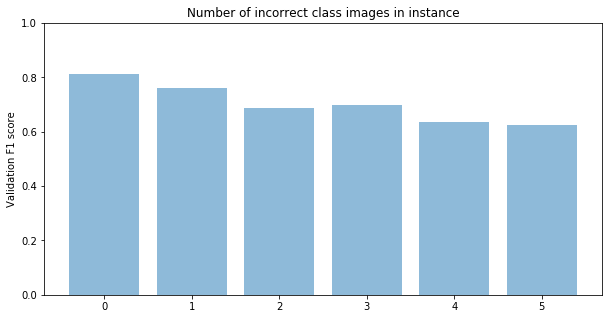

In [14]:
y_pos = np.arange(len(scores))

plt.figure(figsize=(10, 5))
plt.bar(y_pos, scores.values(), align='center', alpha=0.5)
plt.xticks(y_pos, scores.keys())
plt.ylabel('Validation F1 score')
plt.ylim(0, 1)
plt.title('Number of incorrect class images in instance')

plt.show()

The above graph shows that if even a small part of the instance images belongs to an incorrect class, the model performance deteriorates.